In [181]:
# imports and setup 
# Random trees
import pandas as pd
import numpy as np

from sklearn import tree, svm, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
import math as mt

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')
pd.options.display.max_columns = None


In [182]:
career = pd.read_csv('career_v2.csv',index_col=0)
career = career.rename(columns = {"Games Played" : "Games_Played"})


In [183]:
rookie = pd.read_csv('rookie_v2.csv',index_col=0)

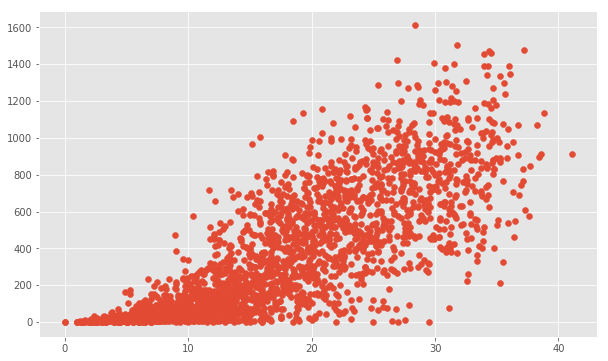

In [184]:
plt.scatter(x = career["MinPerGame"], y = career["Games_Played"])

For the players who don't have information on games started, we will assume that they were starters if they played more than 22 minutes per game.

In [192]:
career['starter'] = np.where(np.logical_and(career['MinPerGame']>=22, career['Games_Played']>=183), 1, 0)

In [193]:
career['All_Star'] = np.where(career['All-Star Games'] >= 1, 1, 0)

In [194]:
career['MVP'] = np.where(career['MVPs'] >= 1, 1, 0)

In [195]:
career['Role_Player'] = np.where(np.logical_and(career['MinPerGame']<22, career['Games_Played']>=183), 1, 0)

In [198]:
career['Bust'] = np.where((career['Games_Played'] < 183), 1, 0)

In [199]:
for index, row in career.iterrows():
    if row['Role_Player'] == 1:
        career.set_value(index,'target','Role_Player')
        if row['All_Star'] == 1:
            career.set_value(index,'target','All_Star')
            if row['MVP'] == 1:
                career.set_value(index,'target','MVP')
    if row['Bust'] == 1:
        career.set_value(index,'target','Bust')
        if row['All_Star'] == 1:
            career.set_value(index,'target','All_Star')
            if row['MVP'] == 1:
                career.set_value(index,'target','MVP')
    if row['starter'] == 1:
        career.set_value(index,'target','Starter')
        if row['All_Star'] == 1:
            career.set_value(index,'target','All_Star')
            if row['MVP'] == 1:
                career.set_value(index,'target','MVP')



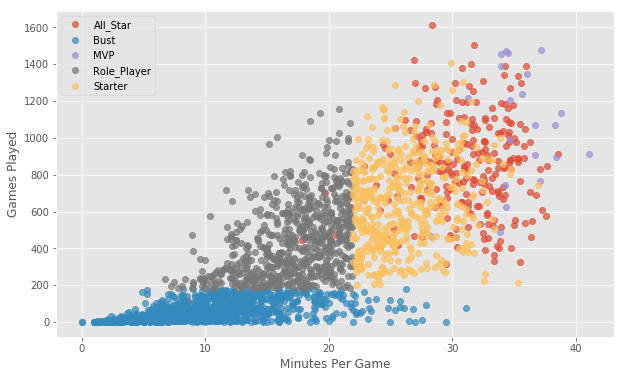

In [200]:
groups = career.groupby('target')
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.MinPerGame, group.Games_Played, marker='o',linestyle='', ms=6,alpha=.7, label=name)
plt.xlabel('Minutes Per Game')
plt.ylabel('Games Played')
ax.legend()

plt.show()

In [201]:
career['target'].replace('MVP', 1,inplace=True)
career['target'].replace('All_Star', 2,inplace=True)
career['target'].replace('Starter', 3,inplace=True)
career['target'].replace('Role_Player', 4,inplace=True)
career['target'].replace('Bust', 5,inplace=True)


In [202]:
target = career[['target']]

In [203]:
target[pd.isnull(target).any(axis=1)]

,target


In [204]:
rookie[['Draft_Pick']] = rookie[['Draft_Pick']].fillna(value=70)

In [205]:
rookie = rookie.fillna(0)

In [208]:
rookie = rookie.drop(['Name','link','Year','Position'],axis=1)

In [209]:
X = scale(rookie.values)
Y = target.values

In [210]:
XTrain, XTest, yTrain, yTest = train_test_split(X, Y, random_state=1,  test_size=0.8)

In [211]:
model = svm.SVC(kernel='rbf',C=1)
model.fit(XTrain, yTrain.ravel())
expected = yTest
predicted = model.predict(XTest)
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_true = expected, y_pred = predicted))

print('Accuracy = ', metrics.accuracy_score(y_true = expected, y_pred = predicted))

Confusion Matrix:
[[  0   9   3   1   4]
 [  0  48  90  35  16]
 [  0  23 183  85  64]
 [  0   0  92 203 227]
 [  0   0  43  99 866]]
Accuracy =  0.621712099474


In [212]:
np.where(predicted == 1)[0]

array([], dtype=int64)

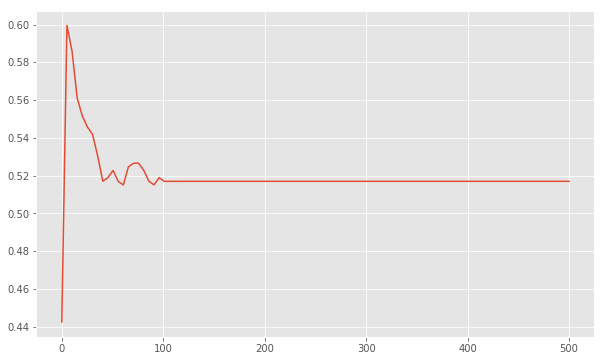

In [213]:
model.get_params()

Cs = np.linspace(.01,500,100)
Accuracies = np.zeros(Cs.shape[0])
for i,C in enumerate(Cs): 
    model = svm.SVC(kernel='rbf', C = C)
    scores = cross_val_score(estimator = model, X = XTrain, y = yTrain.ravel(), cv=4, scoring='accuracy')    
    Accuracies[i]  = scores.mean()
        
plt.plot(Cs,Accuracies)
plt.show()

In [214]:
clf = KNeighborsClassifier(n_neighbors=48)
clf.fit(XTrain, yTrain.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=48, p=2,
           weights='uniform')

In [215]:
print('Confusion Matrix:')
Expected = yTest
Prediction = clf.predict(XTest)
print(metrics.confusion_matrix(y_true = Expected, y_pred = Prediction))

print('Accuracy = ', metrics.accuracy_score(y_true = Expected, y_pred = Prediction))

Confusion Matrix:
[[  0   5  11   1   0]
 [  0  17 111  36  25]
 [  0   2 172 100  81]
 [  0   0  64 187 271]
 [  0   0  31  90 887]]
Accuracy =  0.604017216643


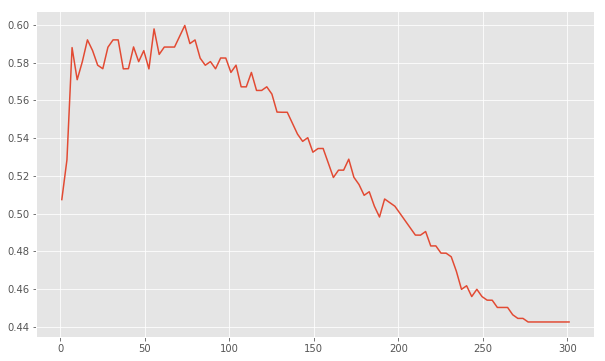

In [216]:
clf.get_params()

Ks = np.linspace(1,301,100)
Accuracies = np.zeros(Ks.shape[0])
for i,K in enumerate(Ks): 
    clf = KNeighborsClassifier(n_neighbors=int(K))
    scores = cross_val_score(estimator = clf, X = XTrain, y = yTrain.ravel(), cv=4, scoring='accuracy')    
    Accuracies[i]  = scores.mean()
        
plt.plot(Ks,Accuracies)
plt.show()

In [217]:
decisionTree = tree.DecisionTreeClassifier(max_depth=3)
decisionTree = decisionTree.fit(XTrain, yTrain)

y_pred_train = decisionTree.predict(XTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

y_pred = decisionTree.predict(XTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_true = yTest, y_pred = y_pred))

print('Accuracy = ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))

Accuracy on training data=  0.639846743295
Accuracy on test data=  0.60306073649
Confusion Matrix:
[[  0  10   5   1   1]
 [  0  52  61  60  16]
 [  0  41 124 113  77]
 [  0   3  51 248 220]
 [  0   0  26 145 837]]
Accuracy =  0.60306073649


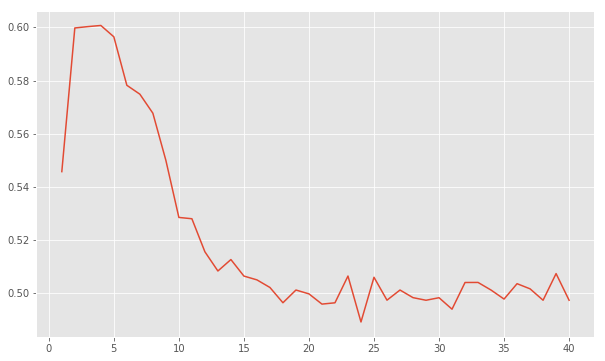

In [218]:
decisionTree.get_params()

Ks = np.linspace(1,40,40)
Accuracies = np.zeros(Ks.shape[0])
for i,K in enumerate(Ks): 
    decisionTree = tree.DecisionTreeClassifier(max_depth=int(K))
    scores = cross_val_score(estimator = decisionTree, X = XTest, y = yTest, cv=5, scoring='accuracy')    
    Accuracies[i]  = scores.mean()
        
plt.plot(Ks,Accuracies)
plt.show()

__Now, I am going to try the same classification but with less predictor variables. I will first start by removing the per 100 variables, after which I'll put those back in and remove the pergame variables__

In [219]:
cols = [c for c in rookie.columns if c[-10:] != 'Per100Poss']
rookie_no100 = rookie[cols]

In [220]:
X = scale(rookie_no100.values)
Y = target.values

XTrain, XTest, yTrain, yTest = train_test_split(X, Y, random_state=1,  test_size=0.8)

model = svm.SVC(kernel='rbf',C=2)
model.fit(XTrain, yTrain.ravel())
expected = yTest
predicted = model.predict(XTest)
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_true = expected, y_pred = predicted))

print('Accuracy = ', metrics.accuracy_score(y_true = expected, y_pred = predicted))

Confusion Matrix:
[[  0   8   3   1   5]
 [  0  51  87  38  13]
 [  0  28 176  94  57]
 [  0   3  94 206 219]
 [  0   0  43  99 866]]
Accuracy =  0.621233859397


In [221]:
clf = KNeighborsClassifier(n_neighbors=48)
clf.fit(XTrain, yTrain.ravel())

print('Confusion Matrix:')
Expected = yTest
Prediction = clf.predict(XTest)
print(metrics.confusion_matrix(y_true = Expected, y_pred = Prediction))

print('Accuracy = ', metrics.accuracy_score(y_true = Expected, y_pred = Prediction))

Confusion Matrix:
[[  0   7   9   0   1]
 [  0  16 113  41  19]
 [  0   5 174 102  74]
 [  0   0  61 198 263]
 [  0   0  30  96 882]]
Accuracy =  0.607364897178


In [222]:
decisionTree = tree.DecisionTreeClassifier(max_depth=3)
decisionTree = decisionTree.fit(XTrain, yTrain)

y_pred_train = decisionTree.predict(XTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

y_pred = decisionTree.predict(XTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_true = yTest, y_pred = y_pred))

print('Accuracy = ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))

Accuracy on training data=  0.649425287356
Accuracy on test data=  0.583931133429
Confusion Matrix:
[[  0  10   6   0   1]
 [  0  52 109  12  16]
 [  0  41 197  40  77]
 [  0   3 164 135 220]
 [  0   0  76  95 837]]
Accuracy =  0.583931133429


__Now keeping per100 and getting rid of per game__

In [72]:
cols = [c for c in rookie.columns if c[-7:] != 'PerGame']
rookie_noPerGame = rookie[cols]

In [73]:
X = scale(rookie_noPerGame.values)
Y = target.values

XTrain, XTest, yTrain, yTest = train_test_split(X, Y, random_state=1,  test_size=0.8)

model = svm.SVC(kernel='rbf',C=1)
model.fit(XTrain, yTrain.ravel())
expected = yTest
predicted = model.predict(XTest)
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_true = expected, y_pred = predicted))

print('Accuracy = ', metrics.accuracy_score(y_true = expected, y_pred = predicted))

Confusion Matrix:
[[  0   8   4   2   3]
 [  0  49  84  44  12]
 [  0  25 164 115  78]
 [  0   2  65 234 221]
 [  0   0  17 109 855]]
Accuracy =  0.622668579627


In [74]:
clf = KNeighborsClassifier(n_neighbors=48)
clf.fit(XTrain, yTrain.ravel())

print('Confusion Matrix:')
Expected = yTest
Prediction = clf.predict(XTest)
print(metrics.confusion_matrix(y_true = Expected, y_pred = Prediction))

print('Accuracy = ', metrics.accuracy_score(y_true = Expected, y_pred = Prediction))

Confusion Matrix:
[[  0   9   7   1   0]
 [  0  23 101  45  20]
 [  0   7 167 118  90]
 [  0   0  59 213 250]
 [  0   0  17 113 851]]
Accuracy =  0.599713055954


In [75]:
decisionTree = tree.DecisionTreeClassifier(max_depth=3)
decisionTree = decisionTree.fit(XTrain, yTrain)

y_pred_train = decisionTree.predict(XTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

y_pred = decisionTree.predict(XTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_true = yTest, y_pred = y_pred))

print('Accuracy = ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))

Accuracy on training data=  0.64367816092
Accuracy on test data=  0.57962697274
Confusion Matrix:
[[  0   8   8   0   1]
 [  0  52 112   6  19]
 [  0  34 235  12 101]
 [  0   7 205  55 255]
 [  0   0  97  14 870]]
Accuracy =  0.57962697274
